# 1. Naive Bayes classification

Accuracy: 0.9264214046822743

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.93       149
           1       0.93      0.92      0.93       150

    accuracy                           0.93       299
   macro avg       0.93      0.93      0.93       299
weighted avg       0.93      0.93      0.93       299

Confusion Matrix:
 [[139  10]
 [ 12 138]]


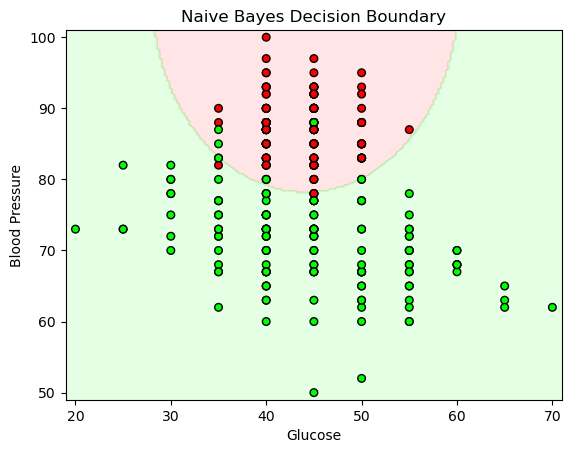

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from matplotlib.colors import ListedColormap

# 1. Load Dataset
data = pd.read_csv("Naive-Bayes-Classification-Data.csv")  # expects columns: glucose, bloodpressure, diabetes
X = data[['glucose', 'bloodpressure']].values
y = data['diabetes'].values

# 2. Data Splitting
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 3. Naive Bayes Implementation from Scratch
class NaiveBayesClassifier:
    def __init__(self):
        self.class_priors = {}
        self.means = {}
        self.vars = {}
        self.classes = None
    
    def fit(self, X, y):
        """Learn priors, mean, and variance per feature for each class."""
        self.classes = np.unique(y)
        for c in self.classes:
            X_c = X[y == c]
            self.class_priors[c] = len(X_c) / len(y)
            self.means[c] = X_c.mean(axis=0)
            self.vars[c] = X_c.var(axis=0) + 1e-9  # avoid division by zero
    
    def _pdf(self, class_idx, x):
        """Gaussian probability density function."""
        mean = self.means[class_idx]
        var = self.vars[class_idx]
        numerator = np.exp(- (x - mean) ** 2 / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator
    
    def _predict_single(self, x):
        """Predict class for a single sample."""
        posteriors = {}
        for c in self.classes:
            prior = np.log(self.class_priors[c])
            likelihood = np.sum(np.log(self._pdf(c, x)))
            posteriors[c] = prior + likelihood
        return max(posteriors, key=posteriors.get)
    
    def predict(self, X):
        return np.array([self._predict_single(x) for x in X])


# 4. Model Training
nb = NaiveBayesClassifier()
nb.fit(X_train, y_train)

# 5. Prediction
y_pred = nb.predict(X_test)

# 6. Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# 7. Visualization of decision boundary
def plot_decision_boundary(X, y, model):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    preds = model.predict(grid).reshape(xx.shape)
    
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00'])
    
    plt.contourf(xx, yy, preds, alpha=0.3, cmap=cmap_light)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=30)
    plt.xlabel("Glucose")
    plt.ylabel("Blood Pressure")
    plt.title("Naive Bayes Decision Boundary")
    plt.show()

plot_decision_boundary(X_test, y_test, nb)


# 2. ID3 Decision Tree

## Load the car evaluation data

In [7]:

# Load car_evaluation.csv or create a small synthetic fallback
car_df = pd.read_csv("car_evaluation.csv")
print("Car dataset shape:", car_df.shape)
display(car_df.head())


Car dataset shape: (1728, 7)


,buying price,maintenance cost,number of doors,number of persons,lug_boot,safety,decision
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


## Define functions for entropy, information gain and decision tree

In [ ]:

from collections import Counter

def entropy(labels):
    """Shannon entropy of label array-like."""
    counts = Counter(labels)
    total = len(labels)
    if total == 0:
        return 0.0
    ent = 0.0
    for c in counts.values():
        p = c / total
        ent -= p * np.log2(p)
    return ent

def information_gain(df, feature, target_col):
    """Information gain of splitting df on 'feature' w.r.t target_col."""
    base_entropy = entropy(df[target_col])
    vals = df[feature].unique()
    weighted_entropy = 0.0
    total = len(df)
    for v in vals:
        subset = df[df[feature] == v]
        weighted_entropy += (len(subset)/total) * entropy(subset[target_col])
    return base_entropy - weighted_entropy

def majority_class(labels):
    return Counter(labels).most_common(1)[0][0]

def build_tree(df, features, target_col, depth=0, max_depth=None):
    """Recursively build ID3 tree.
    - Stops if node is pure, no features remain, or max_depth reached.
    - Returns nested dict: {feature: {value: subtree_or_label, ...}} or a class label (leaf).
    """
    labels = df[target_col].values
    # 1) Pure node
    if len(set(labels)) == 1:
        return labels[0]

    # 2) No features left or max depth reached
    if len(features) == 0 or (max_depth is not None and depth >= max_depth):
        return majority_class(labels)

    # 3) Select best feature by information gain
    gains = [(f, information_gain(df, f, target_col)) for f in features]
    best_feature, best_gain = max(gains, key=lambda x: x[1])

    # If no information gain, return majority
    if best_gain <= 0:
        return majority_class(labels)

    tree = {best_feature: {}}
    for v in df[best_feature].unique():
        subset = df[df[best_feature] == v]
        if subset.empty:
            tree[best_feature][v] = majority_class(labels)
        else:
            remaining = [f for f in features if f != best_feature]
            tree[best_feature][v] = build_tree(subset, remaining, target_col, depth+1, max_depth=None)

    return tree

def predict_one(tree, x_row):
    """Traverse the nested dict tree to classify a single example (Pandas Series)."""
    while isinstance(tree, dict):
        feature = next(iter(tree))
        branches = tree[feature]
        v = x_row.get(feature)
        if v in branches:
            tree = branches[v]
        else:
            # Unseen category: fallback to majority vote among branches (simple heuristic)
            # Take the most common leaf label among immediate children
            leaves = []
            def collect_leaves(node):
                if isinstance(node, dict):
                    for sub in node.values():
                        collect_leaves(sub)
                else:
                    leaves.append(node)
            collect_leaves(branches)
            return majority_class(leaves) if leaves else None
    return tree

def predict(tree, X_df):
    return np.array([predict_one(tree, X_df.iloc[i]) for i in range(len(X_df))])


## Train/test split

In [9]:

# Features are all columns except 'class'
features = [c for c in car_df.columns if c != "decision"]
X = car_df[features].copy()
y = car_df["decision"].copy()

# For ID3 we keep features categorical (strings). Split indices to keep dtypes intact.
train_idx, test_idx = train_test_split(
    np.arange(len(car_df)), test_size=0.30, random_state=42, stratify=y
)

X_train, X_test = X.iloc[train_idx].reset_index(drop=True), X.iloc[test_idx].reset_index(drop=True)
y_train, y_test = y.iloc[train_idx].reset_index(drop=True), y.iloc[test_idx].reset_index(drop=True)

print("Train size:", len(X_train), " Test size:", len(X_test))


Train size: 1209  Test size: 519


## Training

In [10]:

id3_tree = build_tree(pd.concat([X_train, y_train.rename("class")], axis=1),
                      features=features.copy(),
                      target_col="class")

print("Learned Tree (truncated to depth ≤ 3 below):")
id3_tree  # (We also pretty-print below)


{'lug_boot': {'small': 'unacc', 'big': 'acc'}}
{'number of doors': {'4': 'acc', '5more': 'acc', '3': 'acc', '2': {'lug_boot': {'small': 'unacc', 'big': 'acc'}}}}
{'maintenance cost': {'vhigh': 'unacc', 'med': 'acc', 'low': {'number of doors': {'4': 'acc', '5more': 'acc', '3': 'acc', '2': {'lug_boot': {'small': 'unacc', 'big': 'acc'}}}}, 'high': 'unacc'}}
{'lug_boot': {'big': 'acc', 'med': 'acc', 'small': 'unacc'}}
{'number of doors': {'2': {'lug_boot': {'big': 'acc', 'med': 'acc', 'small': 'unacc'}}, '3': 'acc', '5more': 'acc', '4': 'acc'}}
{'lug_boot': {'small': 'unacc', 'big': 'acc', 'med': 'acc'}}
{'number of doors': {'5more': 'acc', '3': 'acc', '4': 'acc', '2': {'lug_boot': {'small': 'unacc', 'big': 'acc', 'med': 'acc'}}}}
{'lug_boot': {'med': 'acc', 'small': 'unacc', 'big': 'acc'}}
{'number of doors': {'5more': 'acc', '3': 'acc', '4': 'acc', '2': {'lug_boot': {'med': 'acc', 'small': 'unacc', 'big': 'acc'}}}}
{'maintenance cost': {'high': {'number of doors': {'2': {'lug_boot': {'bi

{'safety': {'high': {'number of persons': {'more': {'buying price': {'vhigh': {'maintenance cost': {'vhigh': 'unacc',
        'med': 'acc',
        'low': {'number of doors': {'4': 'acc',
          '5more': 'acc',
          '3': 'acc',
          '2': {'lug_boot': {'small': 'unacc', 'big': 'acc'}}}},
        'high': 'unacc'}},
      'high': {'maintenance cost': {'high': {'number of doors': {'2': {'lug_boot': {'big': 'acc',
            'med': 'acc',
            'small': 'unacc'}},
          '3': 'acc',
          '5more': 'acc',
          '4': 'acc'}},
        'vhigh': 'unacc',
        'low': {'number of doors': {'5more': 'acc',
          '3': 'acc',
          '4': 'acc',
          '2': {'lug_boot': {'small': 'unacc', 'big': 'acc', 'med': 'acc'}}}},
        'med': {'number of doors': {'5more': 'acc',
          '3': 'acc',
          '4': 'acc',
          '2': {'lug_boot': {'med': 'acc',
            'small': 'unacc',
            'big': 'acc'}}}}}},
      'med': {'maintenance cost': {'high':

## Prediction & Evaluation (Accuracy)

In [13]:

y_pred_tree = predict(id3_tree, X_test)
acc_tree = accuracy_score(y_test, y_pred_tree)
print("ID3 Accuracy on test set:", acc_tree)


ID3 Accuracy on test set: 0.9383429672447013


## Tree Visualization / Representation
We print the tree up to depth 3.
We also compute depth and breadth.

In [12]:

def print_tree(tree, indent="", depth=0, max_depth=3):
    if not isinstance(tree, dict):
        print(indent + "-> " + str(tree))
        return
    if depth >= max_depth:
        print(indent + "... (subtree truncated)")
        return
    feature = next(iter(tree))
    print(f"{indent}[Split on: {feature}]")
    for val, subtree in tree[feature].items():
        print(f"{indent}  = {val}:")
        print_tree(subtree, indent + "    ", depth+1, max_depth=max_depth)

def tree_depth_and_breadth(tree):
    """Return (depth, breadth) where breadth is the max nodes at any level."""
    if not isinstance(tree, dict):
        return 1, 1
    # BFS to compute breadth per level
    from collections import deque
    q = deque([tree])
    breadth = 0
    depth = 0
    while q:
        level_count = len(q)
        breadth = max(breadth, level_count)
        for _ in range(level_count):
            node = q.popleft()
            if isinstance(node, dict):
                # Enqueue children subtrees
                feature = next(iter(node))
                for sub in node[feature].values():
                    q.append(sub)
        depth += 1
    return depth, breadth

print("Pretty tree (max depth = 3):")
print_tree(id3_tree, max_depth=3)

depth, breadth = tree_depth_and_breadth(id3_tree)
print(f"\nTree depth: {depth}, Tree breadth (max nodes at any level): {breadth}")


Pretty tree (max depth = 3):
[Split on: safety]
  = high:
    [Split on: number of persons]
      = more:
        [Split on: buying price]
          = vhigh:
            ... (subtree truncated)
          = high:
            ... (subtree truncated)
          = med:
            ... (subtree truncated)
          = low:
            ... (subtree truncated)
      = 4:
        [Split on: buying price]
          = low:
            ... (subtree truncated)
          = vhigh:
            ... (subtree truncated)
          = med:
            ... (subtree truncated)
          = high:
            ... (subtree truncated)
      = 2:
        -> unacc
  = med:
    [Split on: number of persons]
      = 2:
        -> unacc
      = 4:
        [Split on: buying price]
          = vhigh:
            ... (subtree truncated)
          = med:
            ... (subtree truncated)
          = high:
            ... (subtree truncated)
          = low:
            ... (subtree truncated)
      = more:
        [Split 